## **Class 15: Regularization**
- **Source**: I, Yeh (1988). Modeling of strength of high-performance concrete using artificial neural networks. Published in Cement and Concrete Research, Vol. 28, No. 12
- **Date**: 02/05/2025
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger()
logger.setLevel(logging.INFO)


### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw =  pd.read_excel('../data/raw/concrete_data.xls')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [3]:
df_raw.sample(10, random_state=2025)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
565,295.80,0.00,0.00,185.70,0.00,1091.4,769.30,7,14.843729
690,288.00,192.00,0.00,192.00,0.00,932.0,717.80,7,23.523542
636,300.00,0.00,0.00,184.00,0.00,1075.0,795.00,28,26.848195
43,380.00,0.00,0.00,228.00,0.00,932.0,670.00,180,53.104131
720,203.50,305.30,0.00,203.50,0.00,963.4,630.00,90,51.863764
346,213.74,0.00,174.74,154.79,10.16,1053.5,776.35,28,40.148187
149,425.00,106.30,0.00,153.50,16.50,852.1,887.10,56,64.300532
376,376.00,0.00,0.00,214.60,0.00,1003.5,762.36,28,31.971002
605,236.00,0.00,0.00,194.00,0.00,968.0,885.00,3,6.467285
436,172.38,13.61,172.37,156.76,4.14,1006.3,856.40,28,33.687797


|Name|Description|Type|Units|
|----|-----------|----|-----|
|cement|Cement (component 1)(kg in a m^3 mixture)|Float|kg/m^3|
|blast_furnace_slag|Blast Furnace Slag (component 2)(kg in a m^3 mixture)|Float|kg/m^3|
|fly_ash|Fly Ash (component 3)(kg in a m^3 mixture)|Float|kg/m^3|
|water|Water (component 4)(kg in a m^3 mixture)|Float|kg/m^3|
|superplasticizer|Superplasticizer (component 5)(kg in a m^3 mixture)|Float|kg/m^3|
|coarse_aggregate|Coarse Aggregate (component 6)(kg in a m^3 mixture)|Float|kg/m^3|
|fine_aggregate|Fine Aggregate (component 7)(kg in a m^3 mixture)|Float|kg/m^3|
|age|Age (day)|Int|day|
|compressive_strength|Concrete compressive strength(MPa, megapascals)|Float|megapascals|

### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = ['cement','blast_furnace_slag','fly_ash','water','superplasticizer','coarse_aggregate','fine_aggregate','age','compressive_strength']  
df = df_baking.copy()
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   blast_furnace_slag    1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   superplasticizer      1030 non-null   float64
 5   coarse_aggregate      1030 non-null   float64
 6   fine_aggregate        1030 non-null   float64
 7   age                   1030 non-null   int64  
 8   compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state =2025)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                824 non-null    float64
 1   blast_furnace_slag    824 non-null    float64
 2   fly_ash               824 non-null    float64
 3   water                 824 non-null    float64
 4   superplasticizer      824 non-null    float64
 5   coarse_aggregate      824 non-null    float64
 6   fine_aggregate        824 non-null    float64
 7   age                   824 non-null    int64  
 8   compressive_strength  824 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 58.1 KB


In [6]:
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
cement,824.0,278.074320,105.202346,102.000000,190.255000,255.000000,350.000000,540.000000
blast_furnace_slag,824.0,76.231311,86.630413,0.000000,0.000000,26.000000,145.000000,359.400000
fly_ash,824.0,53.503083,64.244911,0.000000,0.000000,0.000000,118.270000,200.100000
water,824.0,181.901396,21.936752,121.750000,164.900000,185.700000,193.000000,247.000000
superplasticizer,824.0,6.186624,6.094910,0.000000,0.000000,6.325000,10.300000,32.200000
coarse_aggregate,824.0,971.264211,77.333406,801.000000,932.000000,968.000000,1028.400000,1134.300000
fine_aggregate,824.0,773.822100,80.960805,594.000000,729.750000,779.510000,825.125000,992.600000
age,824.0,46.007282,63.292854,1.000000,12.250000,28.000000,56.000000,365.000000
compressive_strength,824.0,35.512051,16.683885,2.331808,23.728144,33.729166,45.367521,82.599225


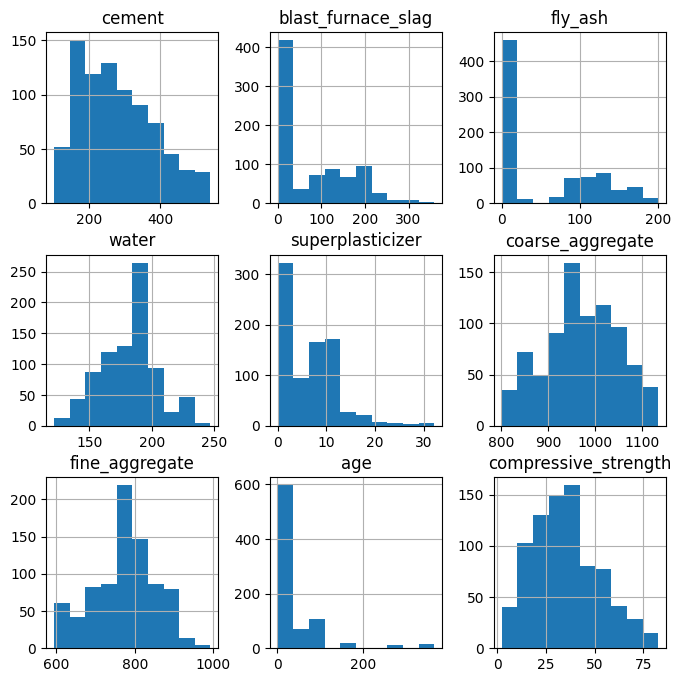

In [7]:
df_train.hist(figsize=(8,8))
plt.show()

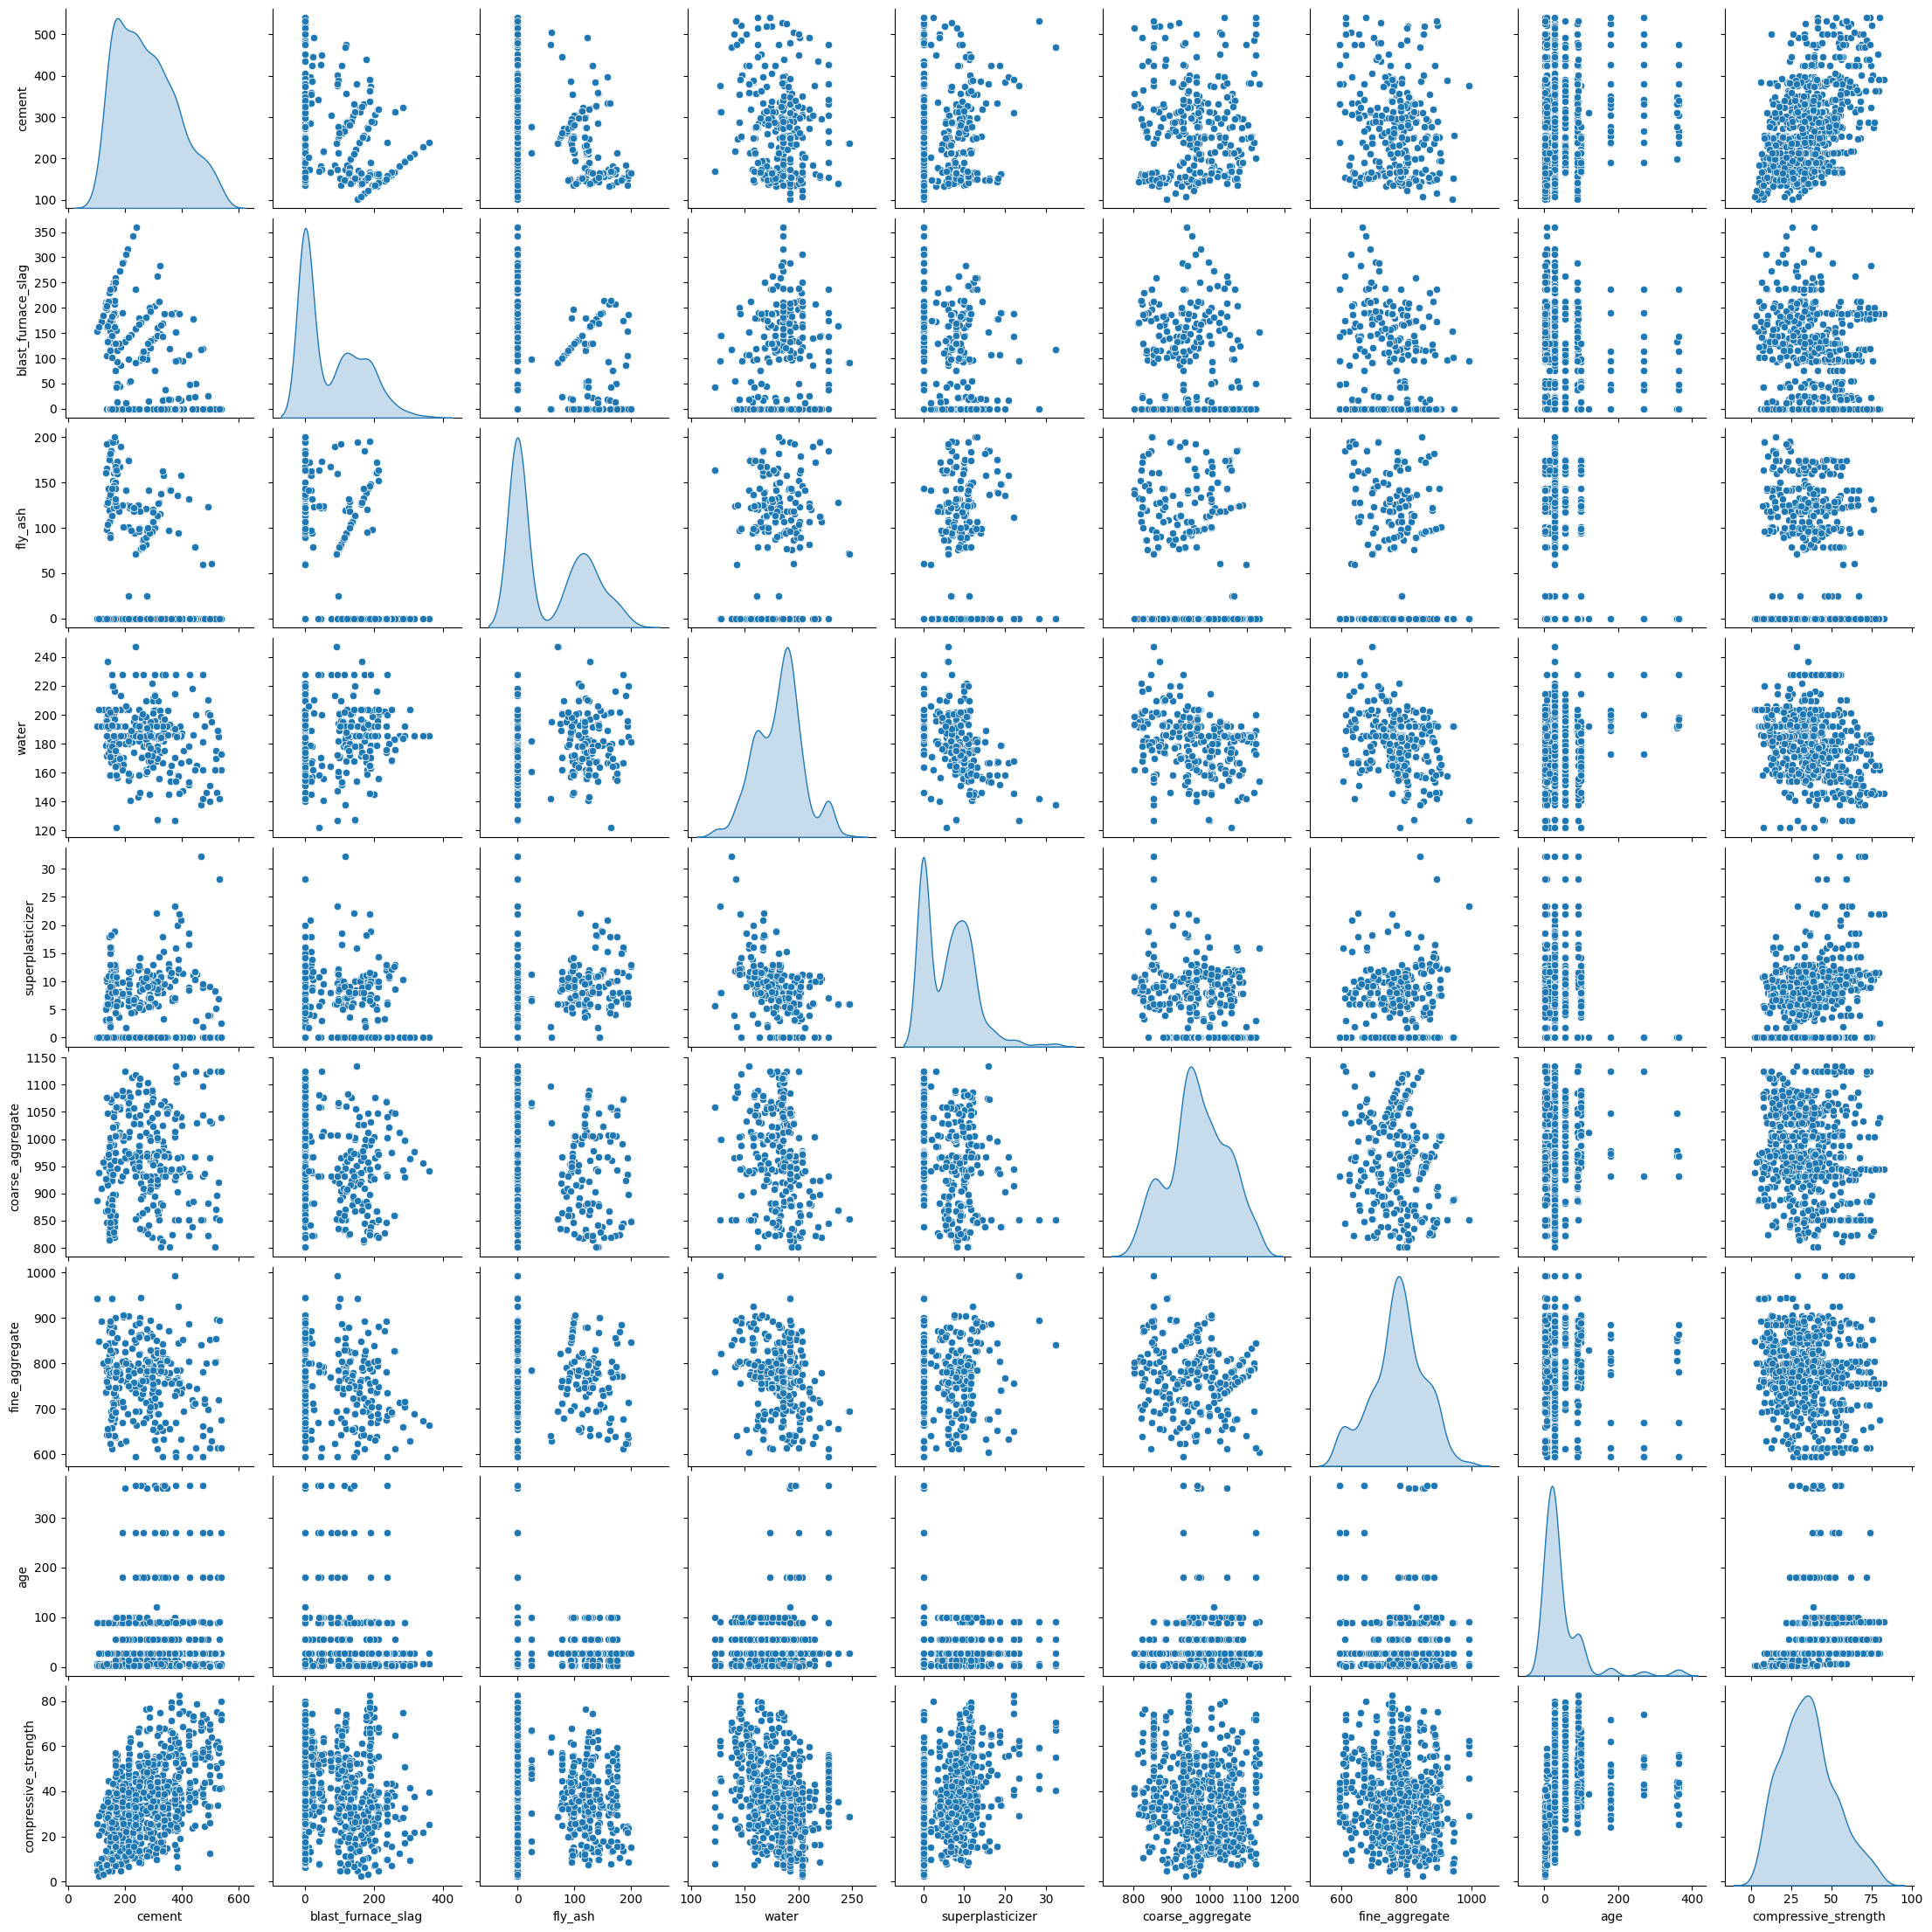

In [8]:
sns.pairplot(df_train,diag_kind='kde')
plt.show()

In [9]:
df_train.corr()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
cement,1.000000,-0.285811,-0.400801,-0.088449,0.106786,-0.124027,-0.205497,0.099587,0.503683
blast_furnace_slag,-0.285811,1.000000,-0.312466,0.105052,0.045337,-0.285798,-0.274075,-0.068910,0.110940
fly_ash,-0.400801,-0.312466,1.000000,-0.239293,0.359434,0.000699,0.062925,-0.144661,-0.088195
water,-0.088449,0.105052,-0.239293,1.000000,-0.653416,-0.185332,-0.466615,0.275804,-0.298594
superplasticizer,0.106786,0.045337,0.359434,-0.653416,1.000000,-0.256387,0.222440,-0.190295,0.387834
coarse_aggregate,-0.124027,-0.285798,0.000699,-0.185332,-0.256387,1.000000,-0.168435,-0.002042,-0.180767
fine_aggregate,-0.205497,-0.274075,0.062925,-0.466615,0.222440,-0.168435,1.000000,-0.167821,-0.146750
age,0.099587,-0.068910,-0.144661,0.275804,-0.190295,-0.002042,-0.167821,1.000000,0.328105
compressive_strength,0.503683,0.110940,-0.088195,-0.298594,0.387834,-0.180767,-0.146750,0.328105,1.000000


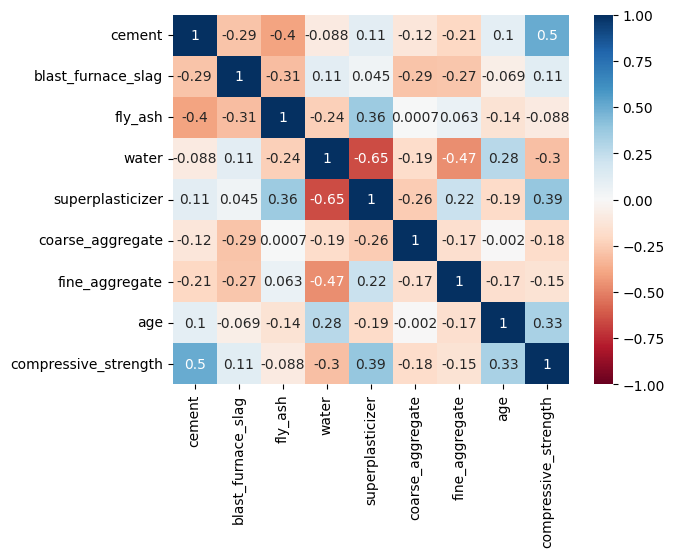

In [10]:
sns.heatmap(df_train.corr(), vmin=-1,vmax=1,cmap='RdBu', annot=True)
plt.show()

#### Rule 0:
Assume that there is a linear relation between the independent variables and the dependent variables

#### Rule 1:
Variables should not be too correlated (More than 0.75 or less than -0.75)

#### Rule 2:
Residuals of our prediction should have a symetrical distribution

#### Rule 3:
The Residuals should have a homogeneous dispersion